In [22]:
import r3.adapters as adapters
import r3.schema as schema
from r3.models.hybrid_models.discrepancy_model import DiscrepancyIVTModel
from r3.models.assimulo.assimulo_model import AssimuloIVTModel
import xgboost
from matplotlib import pyplot as plt

# show the r2 score of the predictions
from sklearn.metrics import r2_score

X_columns = [schema.IVTReactionSchema.pH.value, schema.IVTReactionSchema.TIME_min.value]
y_columns = [schema.IVTReactionSchema.RNA_g_L.value]

experimental_conditions, responses = adapters.DataPipelineAdapter("ricardo_ph").get_all(
    X_columns=X_columns,
    y_columns=y_columns,
    paths=[["ricardo_ph", "csptris"], ["ricardo_ph", "csphepes"]],
    skip_initial_load=True,
)

X_train = experimental_conditions[1][1]
y_train = responses[1][1]

X_test = experimental_conditions[0][1]
y_test = responses[0][1]

assimulo_model = AssimuloIVTModel(
    template=schema.DNATemplates.eGFP, experiment_type=schema.ExperimentType.TIME_SERIES
)

experimental_data = X_train.copy()
experimental_data[schema.IVTReactionSchema.RNA_g_L.value] = y_train.values
assimulo_model.fit(experimental_data, y_columns, is_sequence=True)

📊 Extracted DataFrame with columns ['pH', 'Reaction Time [min]'] and ['RNA [g/L]']
Iter   1 –  R²: 0.501284
Iter   2 –  R²: 0.501284
Iter   3 –  R²: 0.501284
Iter   4 –  R²: 0.501284
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.4747e+01                                    7.78e+00    
Iter   5 –  R²: 0.504542
Iter   6 –  R²: 0.504542
Iter   7 –  R²: 0.504542
Iter   8 –  R²: 0.504542
       1              2         3.4520e+01      2.27e-01       1.28e+06       3.86e-01    
Iter   9 –  R²: 0.504553
Iter  10 –  R²: 0.504553
Iter  11 –  R²: 0.504553
Iter  12 –  R²: 0.504553
       2              3         3.4519e+01      7.87e-04       2.17e+05       5.89e-03    
Iter  13 –  R²: 0.504559
Iter  14 –  R²: 0.504559
Iter  15 –  R²: 0.504559
Iter  16 –  R²: 0.504559
       3              4         3.4519e+01      4.13e-04       8.72e+06       1.15e-03    
Iter  17 –  R²: 0.504571
Iter  18 –  R²: 0.504571
Iter  19 –  

     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [-8.187e-02  1.584e-01  1.054e+00  2.038e+00  2.912e+00
                3.037e+00  2.556e+00  1.190e+00 -9.426e-01 -2.678e+00
               -5.479e+00]
           x: [ 7.932e+03  1.000e+00  1.000e+08]
        cost: 34.51771917670127
         jac: [[ 0.000e+00  0.000e+00  0.000e+00]
               [ 6.605e-05 -6.728e-06 -5.237e-09]
               ...
               [ 6.929e-04 -9.715e-05 -5.494e-08]
               [ 6.933e-04 -9.715e-05 -5.497e-08]]
        grad: [-4.990e-08  7.881e-05 -1.578e-11]
  optimality: 0.00010317354445429557
 active_mask: [0 0 0]
        nfev: 7
        njev: 7

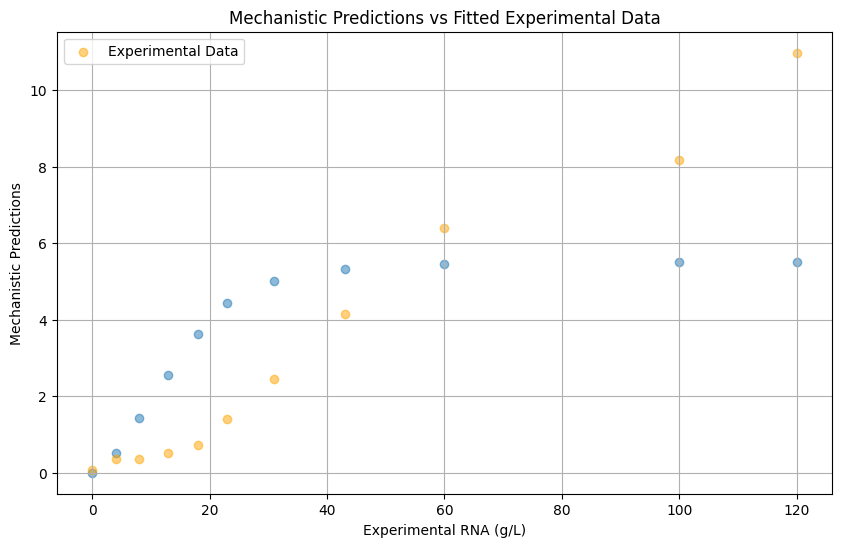

In [23]:
# plot the discrepancy predictions against the experimental data.
assimulo_model.set_predictions_configs(
    X_columns, is_sequence=True, verbose=False, initial_conditions=dict()
)
training_predictions = assimulo_model.predict(X_train.values)
plt.figure(figsize=(10, 6))
plt.scatter(
    X_train[schema.IVTReactionSchema.TIME_min.value].values,
    training_predictions,
    alpha=0.5,
)
plt.scatter(
    X_train[schema.IVTReactionSchema.TIME_min.value].values,
    y_train.values,
    color="orange",
    label="Experimental Data",
    alpha=0.5,
)
plt.xlabel("Experimental RNA (g/L)")
plt.ylabel("Mechanistic Predictions")
plt.title("Mechanistic Predictions vs Fitted Experimental Data")
plt.legend()
plt.grid()
plt.show()

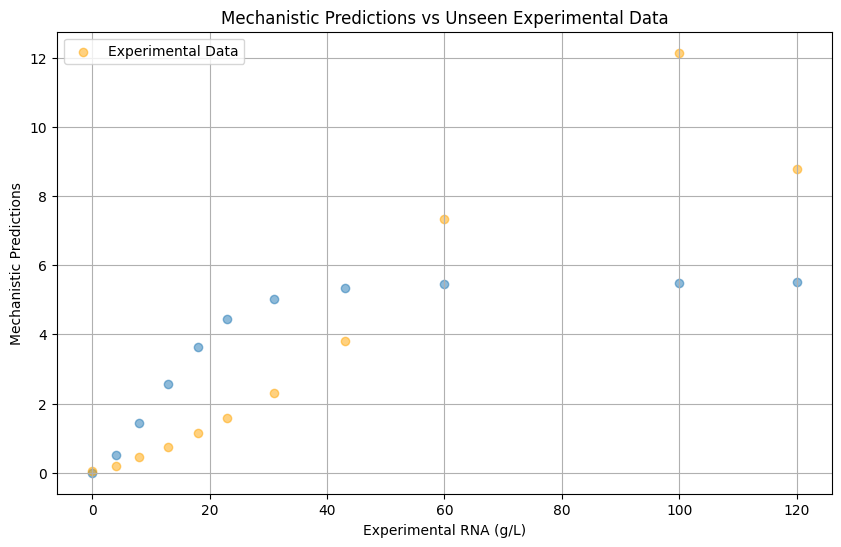

R2 Score: 0.4823


In [24]:
test_predictions = assimulo_model.predict(X_test.values)
plt.figure(figsize=(10, 6))
plt.scatter(
    X_test[schema.IVTReactionSchema.TIME_min.value].values,
    test_predictions,
    alpha=0.5,
)
plt.scatter(
    X_test[schema.IVTReactionSchema.TIME_min.value].values,
    y_test.values,
    color="orange",
    label="Experimental Data",
    alpha=0.5,
)
plt.xlabel("Experimental RNA (g/L)")
plt.ylabel("Mechanistic Predictions")
plt.title("Mechanistic Predictions vs Unseen Experimental Data")
plt.legend()
plt.grid()
plt.show()

# Calculate and print the R2 score
r2 = r2_score(y_test.values, test_predictions)
print(f"R2 Score: {r2:.4f}")

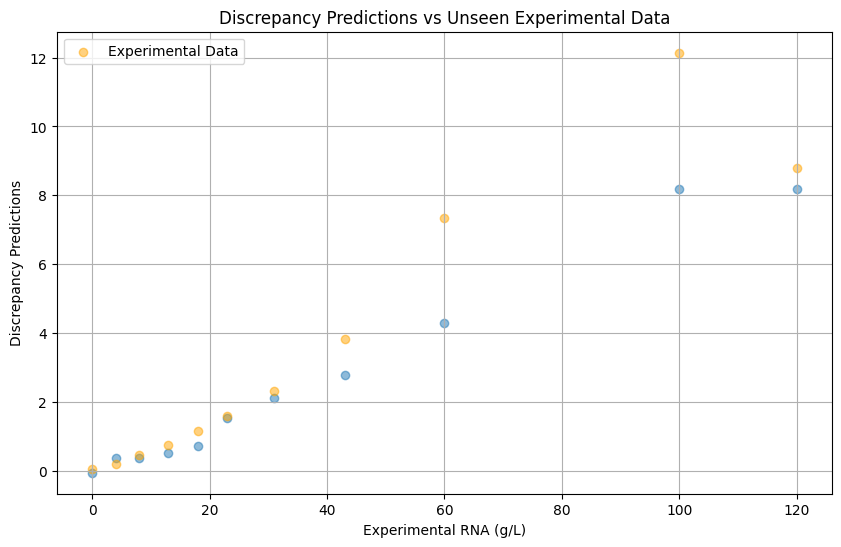

R2 Score of Discrepancy Predictions: 0.8403


In [27]:
# create residuals using the model predictions and build a discrepancy model from the residuals
discrepancy_model = DiscrepancyIVTModel(
    ml_model=xgboost.XGBRegressor(n_estimators=100, max_depth=3, random_state=42),
    assimulo_model=assimulo_model,
    X_columns=X_columns,
)

discrepancy_model.fit(X_train[X_columns].values, y_train.values)

discrepancy_predictions = discrepancy_model.predict(X_test.values)
plt.figure(figsize=(10, 6))
plt.scatter(
    X_test[schema.IVTReactionSchema.TIME_min.value].values,
    discrepancy_predictions,
    alpha=0.5,
)
plt.scatter(
    X_test[schema.IVTReactionSchema.TIME_min.value].values,
    y_test.values,
    color="orange",
    label="Experimental Data",
    alpha=0.5,
)
plt.xlabel("Experimental RNA (g/L)")
plt.ylabel("Discrepancy Predictions")
plt.title("Discrepancy Predictions vs Unseen Experimental Data")
plt.legend()
plt.grid()
plt.show()

r2_discrepancy = r2_score(y_test.values, discrepancy_predictions)
print(f"R2 Score of Discrepancy Predictions: {r2_discrepancy:.4f}")